## **SPLIT ANALYSIS (A/B TESTING...)**

A/B Testing is a statistical method used to compare two versions of something — for example, a web page, product feature, marketing email, or pricing strategy — to determine which one performs better based on a key metric (like click-through rate, conversion rate, or revenue).

You randomly split your audience into two groups:

* Group A (Control) → Sees the original version.

* Group B (Variant) → Sees a new version with one or more changes.

Then, you measure how each group performs and use statistical analysis to decide if the difference is significant (i.e., not just due to chance).

 ### **AB Testing Process**

   * Understanding business problem & data
   *  Detect and resolve problems in the data (Missing Value, Outliers, Unexpected Value)
   * Look summary stats and plots
   * Apply hypothesis testing and check assumptions
   * Check Normality & Homogeneity
   * Apply tests (Shapiro, Levene Test, T-Test, Welch Test, Mann Whitney U Test)
   * Evaluate the results
   * Make inferences
   * Recommend business decision to your customer/director/ceo etc.


### ***Understanding and Processing the Dataset***

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [50]:
df = pd.read_csv('AB_Test_Results.csv')
df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


In [51]:
df.shape

(10000, 3)

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [53]:
df.describe()

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


In [54]:
df.nunique()

USER_ID         6324
VARIANT_NAME       2
REVENUE          101
dtype: int64

In [55]:
df.duplicated().sum()

np.int64(2067)

In [56]:
double_variant_count = df.groupby('USER_ID')['VARIANT_NAME'].nunique().value_counts()
double_variant_count

VARIANT_NAME
1    4783
2    1541
Name: count, dtype: int64

In [57]:
# also look in relative terms
(double_variant_count / double_variant_count.sum() * 100).round(2)

VARIANT_NAME
1    75.63
2    24.37
Name: count, dtype: float64

We see that there are such users and there are quite a lot of them - 24%. If you take these users into account, then the effect of changes in the experiment will be blurred. Therefore, we exclude user data from the calculation of changes in the experiment

In [58]:
user_variant_counts = df.groupby('USER_ID')['VARIANT_NAME'].nunique()
clean_users = user_variant_counts[user_variant_counts == 1].index
df = df[df['USER_ID'].isin(clean_users)]

df.groupby('USER_ID')['VARIANT_NAME'].nunique().value_counts()



VARIANT_NAME
1    4783
Name: count, dtype: int64

In [59]:
df.describe()['REVENUE']

count    6070.000000
mean        0.107064
std         2.673501
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       196.010000
Name: REVENUE, dtype: float64

### ***Data Distribution***

In [60]:
df.sort_values(by='REVENUE', ascending=False).head(10)

,USER_ID,VARIANT_NAME,REVENUE
1437,3342,control,196.01
8168,2166,control,29.32
2482,7356,variant,23.04
6412,1053,control,20.07
5217,3684,variant,19.47
5530,282,control,18.56
758,4445,control,17.05
4031,2059,control,14.24
9019,1973,control,14.07
4561,4966,variant,12.99


<Axes: xlabel='VARIANT_NAME', ylabel='REVENUE'>

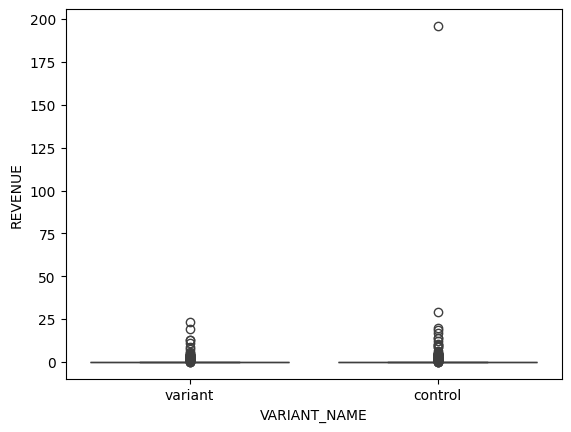

In [61]:
sns.boxplot(x='VARIANT_NAME', y='REVENUE', data=df)

We see that there is only one outlier - in conditions of limited information, we will remove this entry and look at the distribution of data again

In [62]:
df = df[df['USER_ID'] != 3342]


<Axes: xlabel='VARIANT_NAME', ylabel='REVENUE'>

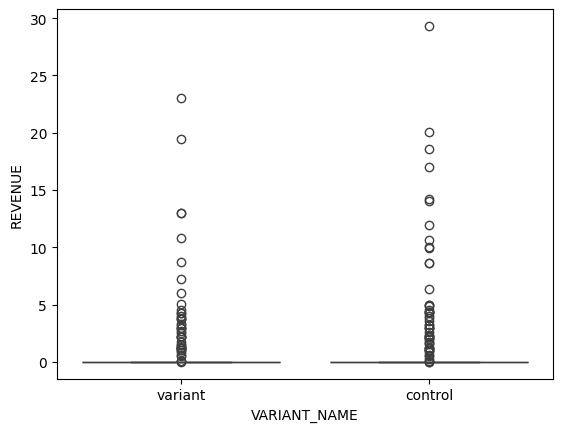

In [63]:
### ***Data Distribution***
sns.boxplot(x='VARIANT_NAME', y='REVENUE', data=df)


In [64]:
import plotly.express as px

# Create a flag for zero vs positive revenue
df['REVENUE_TYPE'] = df['REVENUE'].apply(lambda x: 'All Revenues' if x >= 0 else 'Filtered (REVENUE > 0)')

# Combine both cases into one DataFrame
df_combined = pd.concat([
    df.assign(REVENUE_TYPE='All Revenues'),
    df[df['REVENUE'] > 0].assign(REVENUE_TYPE='REVENUE > 0')
])

# Create Plotly boxplot
fig = px.box(
    df_combined,
    x='VARIANT_NAME',
    y='REVENUE',
    color='REVENUE_TYPE',
    title='Revenue Distribution by Variant (All vs >0)',
    labels={'VARIANT_NAME': 'Variant', 'REVENUE': 'Revenue'},
    boxmode='group'
)

# Optional styling
fig.update_layout(
    xaxis=dict(title='Variant', tickvals=['control', 'variant']),
    yaxis_title='Revenue',
    width=600,
    height=600
)

fig.show()


When considering All Revenues, the blue boxplots are heavily skewed towards zero, indicating that a vast majority of users in both groups generated no revenue. 

When focusing only on REVENUE > 0, the red boxplots show the distribution of actual spending.

For both the 'variant' and 'control' groups, the median revenue (the line inside the red box) for paying users appears to be around $3, with the interquartile range (the box itself) spanning approximately from $1 to $5. Both groups also contain significant outliers, with some users generating revenues near $30. The distributions of positive revenue appear very similar between the 'variant' and 'control' groups.

In [65]:
# A/B Groups & Target Summary Stats
df.groupby("USER_ID")['REVENUE'].agg(["count", "median", "mean", "std", "max", 'sum']).sort_values(by='sum', ascending=False)

,count,median,mean,std,max,sum
USER_ID,,,,,,
2166,2,14.66,14.6600,20.732371,29.32,29.32
7356,1,23.04,23.0400,NaN,23.04,23.04
1053,4,0.00,5.0175,10.035000,20.07,20.07
3684,1,19.47,19.4700,NaN,19.47,19.47
282,2,9.28,9.2800,13.123902,18.56,18.56
...,...,...,...,...,...,...
9990,1,0.00,0.0000,NaN,0.00,0.00
9992,1,0.00,0.0000,NaN,0.00,0.00
9993,1,0.00,0.0000,NaN,0.00,0.00


From this it shows that some users appear twice despite having removed users that are in both variant and control. Let's explore.

In [ ]:
#show user with id 1053
df[df['USER_ID'] == 1053]


,USER_ID,VARIANT_NAME,REVENUE,REVENUE_TYPE
2617,1053,control,0.00,All Revenues
2853,1053,control,0.00,All Revenues
6412,1053,control,20.07,All Revenues
7514,1053,control,0.00,All Revenues


These users only exist in a specific variant type with different revenue, so we combine to produce a record per user.

In [67]:
#users who have records with zero and positive revenue
df.loc[
    (df['REVENUE'] == 0) & 
    (df['USER_ID'].isin(df.loc[df['REVENUE'] > 0, 'USER_ID'].values)),
    'USER_ID'
].count()


np.int64(52)

In [68]:
df.loc[
    (df['REVENUE'] == 0) & 
    (df['USER_ID'].isin(df.loc[df['REVENUE'] > 0, 'USER_ID'].values)),
    'USER_ID'
].nunique()


37

In [69]:
df = df.groupby(by=['USER_ID', 'VARIANT_NAME']).sum().reset_index()

In [72]:


df_all = df.assign(Type='All Revenue')
df_pos = df[df['REVENUE'] > 0].assign(Type='Revenue > 0')
df_combined = pd.concat([df_all, df_pos])

fig = px.box(
    df_combined[df_combined['VARIANT_NAME'].isin(['control', 'variant'])],
    x='VARIANT_NAME', y='REVENUE', color='Type',
    boxmode='group',
    title='Revenue by Variant (All vs > 0)'
)

fig.show()




It should be noted that during the transformation, the quantiles in the test group increased

It can be seen that in the test group, almost all quantile statistics, except for the minimum, are at a slightly lower level.

In [73]:
# get metrics by groups
all_stat = df.groupby(by='VARIANT_NAME').agg({'USER_ID': 'nunique',
                                               'REVENUE': ['sum', 'mean', 'median', 'count']})

# create two additional metrics to see relative changes
orders_per_user = all_stat.loc[:, ('REVENUE', 'count')] / all_stat.loc[:, ('USER_ID', 'nunique')]
revenue_per_user = all_stat.loc[:, ('REVENUE', 'sum')] / all_stat.loc[:, ('USER_ID', 'nunique')]

# add them to the rest of the metrics in a separate group
all_stat.loc[:, ('per_user', 'orders')] = orders_per_user
all_stat.loc[:, ('per_user', 'revenue')] = revenue_per_user

all_stat

USER_ID REVENUE                        per_user          
             nunique     sum      mean median count   orders   revenue
VARIANT_NAME                                                          
control         2389  274.55  0.114923    0.0  2389      1.0  0.114923
variant         2393  179.32  0.074935    0.0  2393      1.0  0.074935

In [74]:
# get metrics by groups for only users with positive revenue
paid_stat = df.loc[df.REVENUE != 0].groupby(by='VARIANT_NAME').agg({'USER_ID': 'nunique',
                                                                     'REVENUE': ['sum', 'mean', 'median', 'count']})

# add two additional metrics to see relative changes
orders_per_user = paid_stat.loc[:, ('REVENUE', 'count')] / paid_stat.loc[:, ('USER_ID', 'nunique')]
revenue_per_user = paid_stat.loc[:, ('REVENUE', 'sum')] / paid_stat.loc[:, ('USER_ID', 'nunique')]
paid_stat.loc[:, ('per_user', 'orders')] = orders_per_user
paid_stat.loc[:, ('per_user', 'revenue')] = revenue_per_user

paid_stat

USER_ID REVENUE                        per_user          
             nunique     sum      mean median count   orders   revenue
VARIANT_NAME                                                          
control           53  274.55  5.180189   2.99    53      1.0  5.180189
variant           42  179.32  4.269524   2.97    42      1.0  4.269524

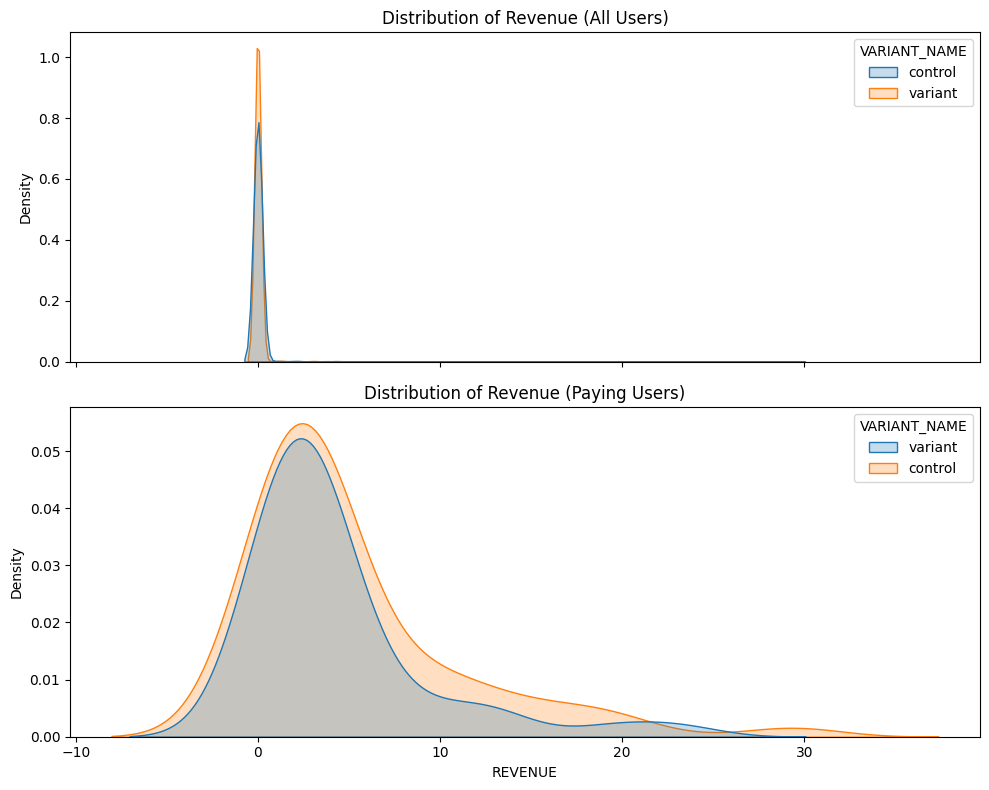

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, figsize=(10, 8), sharex=True)

# All users
sns.kdeplot(data=df, x='REVENUE', hue='VARIANT_NAME', ax=axes[0], fill=True)
axes[0].set_title('Distribution of Revenue (All Users)')

# Paying users only
sns.kdeplot(data=df[df['REVENUE'] > 0], x='REVENUE', hue='VARIANT_NAME', ax=axes[1], fill=True)
axes[1].set_title('Distribution of Revenue (Paying Users)')

plt.tight_layout()
plt.show()


### ***Statistical Analysis***

 Is there a significant difference between the average REVENUE of the control and variant groups ?

* H0: Data is a normal distribution
* H1: Data is a non-normal distribution



In [79]:
df.groupby('VARIANT_NAME').agg({'REVENUE': ['sum', 'count']}).reset_index()

VARIANT_NAME REVENUE      
                   sum count
0      control  274.55  2389
1      variant  179.32  2393

steps to carry-out teseting:
* Split & Define Control Group & Test Group
* Apply Shapiro Test for normality
* If parametric apply Levene Test for homogeneity of variances
* If Parametric + homogeneity of variances apply T-Test
* If Parametric - homogeneity of variances apply Welch Test
* If Non-parametric apply Mann Whitney U Test directly

In [80]:

from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu

def AB_Test(df, group, target, A, B):
    A_data = df.loc[df[group] == A, target]
    B_data = df.loc[df[group] == B, target]
    
    # Normality test (Shapiro-Wilk)
    A_norm, B_norm = shapiro(A_data).pvalue > 0.05, shapiro(B_data).pvalue > 0.05
    
    if A_norm and B_norm:
        # Homogeneity of variances
        equal_var = levene(A_data, B_data).pvalue > 0.05
        p_val = ttest_ind(A_data, B_data, equal_var=equal_var).pvalue
        test_type = f"Parametric (T-test, equal_var={equal_var})"
    else:
        p_val = mannwhitneyu(A_data, B_data).pvalue
        test_type = "Non-Parametric (Mann-Whitney U)"
    
    # Results summary
    result = pd.DataFrame({
        "Test Type": [test_type],
        "p-value": [p_val],
        "Decision (α=0.05)": ["Reject H₀" if p_val < 0.05 else "Fail to Reject H₀"],
        "Interpretation": ["Groups differ significantly" if p_val < 0.05 else "No significant difference"]
    })

    print("# A/B Test Hypotheses\nH₀: A == B\nH₁: A ≠ B\n")
    return result

# Run test
AB_Test(df, "VARIANT_NAME", "REVENUE", "control", "variant")


# A/B Test Hypotheses
H₀: A == B
H₁: A ≠ B



,Test Type,p-value,Decision (α=0.05),Interpretation
0,Non-Parametric (Mann-Whitney U),0.247996,Fail to Reject H₀,No significant difference


The A/B test indicates no statistically significant difference in revenue between the control and variant groups   (p = 0.248), suggesting the new variant did not outperform the control.